In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('./data', 'train.csv')
test_data_path = join('./data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train['yr_renovated'].value_counts()

train data dim : (15035, 21)
test data dim : (6555, 20)


yr_renovated
0       14404
2014       71
2013       28
2003       25
2000       25
        ...  
1950        1
1946        1
1940        1
1976        1
1944        1
Name: count, Length: 65, dtype: int64

In [3]:
train.info()
#연속형 변수 : price, sqft_above, sqft_basement, sqft_living, sqft_lot ...
#순서형 변수 : waterfront, view, condition, grade, year, yr_built, yr_renovated...
#위치 관련 변수 : zipcode, lat, long -> 분명 의미있는 지표이지만 전처리는 시간상 다음 기회에

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [4]:
# 데이터 전처리
## 결측치 확인 -> 없음
## 중복 데이터 확인 -> 없음

print(train.isnull().sum().values.sum())
train[train.duplicated()]

0


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [5]:
# 데이터 전처리
## date -> year, month, day로 분리가능하나 가격에 영향을 주는건 지은 연도일것 같아 year만 분리
## id 삭제
train['year'] = train['date'].apply(lambda x : str(x[:4])).astype(int)

del train['date']
del train['id']

test['year'] = test['date'].apply(lambda x : str(x[:4])).astype(int)

del test['date']

In [6]:
# 데이터 전처리
##yr_renovated - 재건축 년도 ; 0의 경우 재건축 X => 0 , 1 로 categorical 변수로 처리하는게 적절하다고 생각

print(train['yr_renovated'].value_counts())

train['yr_renovated'] = train['yr_renovated'].apply(lambda x: 1 if x == 0 else 0)

print(train['yr_renovated'].value_counts())
print(train.columns)

yr_renovated
0       14404
2014       71
2013       28
2003       25
2000       25
        ...  
1950        1
1946        1
1940        1
1976        1
1944        1
Name: count, Length: 65, dtype: int64
yr_renovated
1    14404
0      631
Name: count, dtype: int64
Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year'],
      dtype='object')


In [7]:
# 데이터 전처리
## 이상치 확인
## 한쪽으로 치우친 상황이 많았음으로 baseline에 따라 log 변환 후 이상치 확인
## 극심한 이상치 중 전체 데이터 크기의 1% 미만인 경우 삭제 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # 1사분위수
    Q3 = df[column].quantile(0.75)  # 3사분위수
    IQR = Q3 - Q1  # IQR 계산

    # 이상치 조건
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치 인덱스 반환
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
    return outliers

columns = [col for col in train.columns if col != 'price']

for col in columns:
    outliers = detect_outliers(train, col)
    print(f"Column '{col}': {len(outliers)} outliers detected.")



Column 'bedrooms': 364 outliers detected.
Column 'bathrooms': 395 outliers detected.
Column 'sqft_living': 71 outliers detected.
Column 'sqft_lot': 1776 outliers detected.
Column 'floors': 0 outliers detected.
Column 'waterfront': 107 outliers detected.
Column 'view': 1487 outliers detected.
Column 'condition': 21 outliers detected.
Column 'grade': 1339 outliers detected.
Column 'sqft_above': 33 outliers detected.
Column 'sqft_basement': 0 outliers detected.
Column 'yr_built': 0 outliers detected.
Column 'yr_renovated': 631 outliers detected.
Column 'zipcode': 0 outliers detected.
Column 'lat': 2 outliers detected.
Column 'long': 186 outliers detected.
Column 'sqft_living15': 397 outliers detected.
Column 'sqft_lot15': 1546 outliers detected.
Column 'year': 0 outliers detected.


In [8]:
# 삭제할 컬럼 지정
target_columns = ['sqft_living', 'condition', 'sqft_above']

# 이상치 인덱스 수집
outlier_indices = set()  # 중복 제거를 위해 set 사용
for col in target_columns:
    if train[col].dtype in ['float64', 'int64']:  # 수치형 데이터만 처리
        outliers = detect_outliers(train, col)
        outlier_indices.update(outliers)  # 인덱스 추가

# 이상치 삭제
train.drop(index=outlier_indices, inplace=True)

# 데이터프레임 갱신 확인
print(f"Remaining rows after outlier removal: {train.shape}")

Remaining rows after outlier removal: (14938, 20)


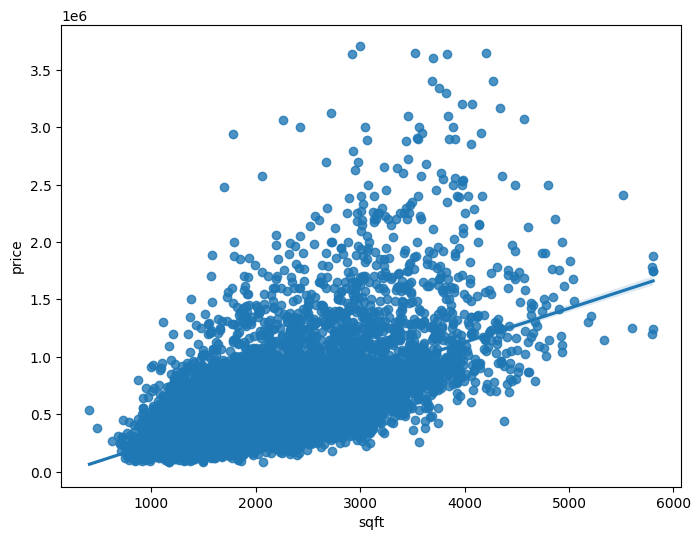

In [9]:
# 피처 엔지니어링
## sqft_ above,basement,living15,lot15 : 집의 면적을 특정 기준으로 구분해 놓은 변수들 / 15의 경우 재건축 여부에 따라 또 달라질 수 있다고함
## 이 변수들을 모두 합쳤을 때 price와의 상관관계가 존재하는지 확인 -> 그럴듯한 조합을 찾아 피처에 추가
## 해당 조합들을 변경해가면 실제로 실험해볼만하다고 생각

sqft = train['sqft_basement'] + train['sqft_above'] + train['sqft_living15']
sqft.name = "sqft"
data = pd.concat([train['price'], sqft], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft', y="price", data=data)

train['sqft'] = train['sqft_basement'] + train['sqft_above'] + train['sqft_living15']
test['sqft'] = test['sqft_basement'] + test['sqft_above'] + test['sqft_living15']

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = train.drop('price', axis=1)
y = train['price']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20],
    },
    "LightGBM": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "num_leaves": [31, 63],
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 6],
    }
}

In [12]:
from sklearn.model_selection import GridSearchCV

best_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(model, param_grids[name], scoring='neg_mean_squared_error', cv=2, n_jobs=4)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")

Training RandomForest...


Best params for RandomForest: {'max_depth': 20, 'n_estimators': 200}
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 5228, number of used features: 20
[LightGBM] [Info] Start training from score 533661.328806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in t

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [27]:
print(best_models)

{'RandomForest': RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42), 'LightGBM': LGBMRegressor(n_estimators=200, random_state=42)}


In [14]:
from sklearn.metrics import mean_squared_error

preds = []
for name, model in best_models.items():
    pred = model.predict(X_val)
    preds.append(pred)
    print(f"{name} MSE: {mean_squared_error(y_val, pred)}")

RandomForest MSE: 15152843453.319424
LightGBM MSE: 11951302265.414694


In [ ]:
# 5. 앙상블 (Blending)
# 각 모델의 예측값 평균
preds = []
for name, model in best_models.items():
    pred = model.predict(X_val)
    preds.append(pred)
    print(f"{name} MSE: {mean_squared_error(y_val, pred)}")

final_pred = np.mean(preds, axis=0)
final_mse = mean_squared_error(y_val, final_pred)
print(f"Final Blended Model MSE: {final_mse}")



# 6. 결과 저장 (캐글 제출용 CSV 생성)
lgb_model = best_models['LightGBM']
X = test.drop('id', axis=1)
test_preds = lgb_model.predict(X)

submission = pd.DataFrame({'id': test['id'], 'Price': test_preds})
submission.to_csv('./data/submission.csv', index=False)

RandomForest MSE: 15152843453.319424
LightGBM MSE: 11951302265.414694
Final Blended Model MSE: 12647581854.59372


KeyError: "['id'] not found in axis"